# Exploring the Data


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
from datetime import date
from datetime import datetime
from sklearn import tree


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')

# View the first and last few rows of the data
df.head(len(df))


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [3]:
# Get summary statistics for the data
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


see how many nonzero entries there are

In [4]:
print(sum(df['sales']!=0))

print("% of nonzero is: " , np.round(sum(df['sales']!=0)/sum(df['sales']),4)  )

2061758
% of nonzero is:  0.0019


makes sense, most products are not sold daily (only essential products are) 

## Try random forest

for this we have to masssage the data a bit

In [5]:
df2 = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv',
    index_col='id',
    parse_dates=['date'])
df2.head(len(df2))

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


Define the target variable (the one we are going to predict) 

In [6]:
y = df2.sales

See which are the features we can use for the prediction (in principle we can use the variables that are numerical)

In [7]:
df2.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

first we need to make the date into an integer or float

In [8]:
# An example
from datetime import datetime
curr_dt = datetime.now()
print("Current datetime: ", curr_dt)
timestamp = int(round(curr_dt.timestamp()))
print("Integer timestamp of current datetime: ",
      timestamp)

Current datetime:  2023-05-31 08:22:36.833817
Integer timestamp of current datetime:  1685521357


In [9]:
# apply to all
df2['date_int'] = df2['date'].map(lambda a : int(round(a.timestamp())) )
df2.head(len(df2))

,date,store_nbr,family,sales,onpromotion,date_int
id,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0,1356998400
1,2013-01-01,1,BABY CARE,0.000,0,1356998400
2,2013-01-01,1,BEAUTY,0.000,0,1356998400
3,2013-01-01,1,BEVERAGES,0.000,0,1356998400
4,2013-01-01,1,BOOKS,0.000,0,1356998400
...,...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0,1502755200
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1502755200
3000885,2017-08-15,9,PRODUCE,2419.729,148,1502755200


In [10]:
print("Check that the difference between time integer timestamps is always the same:")
print(" ")
print(df2.loc[0,'date'], df2.loc[0,'date_int'])
print(df2.loc[1782,'date'], df2.loc[1782,'date_int'])
print(df2.loc[3564,'date'], df2.loc[3564,'date_int'])
print(df2.loc[5346,'date'], df2.loc[5346,'date_int'])
print(df2.loc[5346,'date_int']-df2.loc[3564,'date_int'], df2.loc[3564,'date_int']-df2.loc[1782,'date_int'], df2.loc[1782,'date_int']-df2.loc[0,'date_int'])

Check that the difference between time integer timestamps is always the same:
 
2013-01-01 00:00:00 1356998400
2013-01-02 00:00:00 1357084800
2013-01-03 00:00:00 1357171200
2013-01-04 00:00:00 1357257600
86400 86400 86400


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   date_int     int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 224.8+ MB


In [12]:
family_enum = {}
family_array = df2['family'].unique()
for i in range(len(family_array)):
    family_enum[family_array[i]] = i
print(family_enum)

{'AUTOMOTIVE': 0, 'BABY CARE': 1, 'BEAUTY': 2, 'BEVERAGES': 3, 'BOOKS': 4, 'BREAD/BAKERY': 5, 'CELEBRATION': 6, 'CLEANING': 7, 'DAIRY': 8, 'DELI': 9, 'EGGS': 10, 'FROZEN FOODS': 11, 'GROCERY I': 12, 'GROCERY II': 13, 'HARDWARE': 14, 'HOME AND KITCHEN I': 15, 'HOME AND KITCHEN II': 16, 'HOME APPLIANCES': 17, 'HOME CARE': 18, 'LADIESWEAR': 19, 'LAWN AND GARDEN': 20, 'LINGERIE': 21, 'LIQUOR,WINE,BEER': 22, 'MAGAZINES': 23, 'MEATS': 24, 'PERSONAL CARE': 25, 'PET SUPPLIES': 26, 'PLAYERS AND ELECTRONICS': 27, 'POULTRY': 28, 'PREPARED FOODS': 29, 'PRODUCE': 30, 'SCHOOL AND OFFICE SUPPLIES': 31, 'SEAFOOD': 32}


In [13]:
df2['family_number'] = df2['family'].map(lambda a : family_enum[a] )
df2.head()

,date,store_nbr,family,sales,onpromotion,date_int,family_number
id,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,1356998400,0
1,2013-01-01,1,BABY CARE,0.0,0,1356998400,1
2,2013-01-01,1,BEAUTY,0.0,0,1356998400,2
3,2013-01-01,1,BEVERAGES,0.0,0,1356998400,3
4,2013-01-01,1,BOOKS,0.0,0,1356998400,4


In [14]:
features = [ 'date_int', 'store_nbr', 'family_number', 'onpromotion']
x = df2[features]
x.head(len(x))

,date_int,store_nbr,family_number,onpromotion
id,,,,
0,1356998400,1,0,0
1,1356998400,1,1,0
2,1356998400,1,2,0
3,1356998400,1,3,0
4,1356998400,1,4,0
...,...,...,...,...
3000883,1502755200,9,28,0
3000884,1502755200,9,29,1
3000885,1502755200,9,30,148


In [15]:
from sklearn.tree import DecisionTreeRegressor

# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(random_state=1)

# Fit model
tree_model.fit(x, y)

DecisionTreeRegressor(random_state=1)

## Oil data

In [16]:
df_oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv',
    parse_dates=['date'])
df_oil.head(len(df_oil))

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


Weekends are missing, and data includes test-data dates, from 08-16 to 08-31 2017.

Add day-of-week column so that we can use it to add weekends. Add date_int column which will be used to merge this dataframe to the original one.

In [17]:
df_oil['date_int'] = df_oil['date'].map(lambda a : int(round(a.timestamp())) )
df_oil['day_of_week']=df_oil['date'].dt.weekday
df_oil.head(len(df_oil))

,date,dcoilwtico,date_int,day_of_week
0,2013-01-01,NaN,1356998400,1
1,2013-01-02,93.14,1357084800,2
2,2013-01-03,92.97,1357171200,3
3,2013-01-04,93.12,1357257600,4
4,2013-01-07,93.20,1357516800,0
...,...,...,...,...
1213,2017-08-25,47.65,1503619200,4
1214,2017-08-28,46.40,1503878400,0
1215,2017-08-29,46.46,1503964800,1
1216,2017-08-30,45.96,1504051200,2


Add weekends, by adding a row after every Friday (day_of_week = 4) and before every Monday (day_of_week = 0).
To fill in the 'date' we simply write 'Saturday' and 'Sunday', since we will not use this column to train the forest anyway.
As for oil prices, the on of Sat is the same as Friday, the one of Sun is the same as Monday. The average may be a better option (I just didn't manage for now..)

In [18]:
df_oil_Saturday = (pd.concat([df_oil[df_oil.day_of_week==4].assign(date='Saturday', day_of_week = 5, date_int = (df_oil[df_oil.day_of_week==4].date_int+86400)), df_oil])
                   .sort_index().reset_index(drop=True))
df_oil_weekend = (pd.concat([df_oil_Saturday, df_oil_Saturday[df_oil_Saturday.day_of_week==0].assign(date='Sunday', day_of_week = 6, date_int = (df_oil_Saturday[df_oil_Saturday.day_of_week==0].date_int-86400))])
                   .sort_index().reset_index(drop=True))
#The above is switching Fridays and Saturdays from the 2nd weekend onwards (WTF??), so let's order by date_int as a suboptimal solution:
df_oil_weekend = df_oil_weekend.sort_values('date_int').reset_index(drop=True)

In [19]:
df_oil_weekend.head(20)

,date,dcoilwtico,date_int,day_of_week
0,2013-01-01 00:00:00,NaN,1356998400,1
1,2013-01-02 00:00:00,93.14,1357084800,2
2,2013-01-03 00:00:00,92.97,1357171200,3
3,2013-01-04 00:00:00,93.12,1357257600,4
4,Saturday,93.12,1357344000,5
5,Sunday,93.20,1357430400,6
6,2013-01-07 00:00:00,93.20,1357516800,0
7,2013-01-08 00:00:00,93.21,1357603200,1
8,2013-01-09 00:00:00,93.08,1357689600,2
9,2013-01-10 00:00:00,93.81,1357776000,3


## Merge oil feature to rest

In [20]:
print(df_oil_weekend.columns)
print(df2.columns)

Index(['date', 'dcoilwtico', 'date_int', 'day_of_week'], dtype='object')
Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'date_int',
       'family_number'],
      dtype='object')


In [21]:
df_merged = pd.merge(df2[['date', 'date_int', 'store_nbr', 'family_number', 'sales', 'onpromotion']]
                     , df_oil_weekend[['dcoilwtico', 'day_of_week', 'date_int']], on="date_int", how="left")
df_merged.head(len(df_merged))

,date,date_int,store_nbr,family_number,sales,onpromotion,dcoilwtico,day_of_week
0,2013-01-01,1356998400,1,0,0.000,0,NaN,1
1,2013-01-01,1356998400,1,1,0.000,0,NaN,1
2,2013-01-01,1356998400,1,2,0.000,0,NaN,1
3,2013-01-01,1356998400,1,3,0.000,0,NaN,1
4,2013-01-01,1356998400,1,4,0.000,0,NaN,1
...,...,...,...,...,...,...,...,...
3000883,2017-08-15,1502755200,9,28,438.133,0,47.57,1
3000884,2017-08-15,1502755200,9,29,154.553,1,47.57,1
3000885,2017-08-15,1502755200,9,30,2419.729,148,47.57,1
3000886,2017-08-15,1502755200,9,31,121.000,8,47.57,1


The above produces dataframe already up to 2017-08-15, so we don't need to crop out test data that originally sits in the oil dataframe. Also Christmas days are not there:

In [22]:
print(pd.Timestamp('2013-12-24 00:00:00') in df_merged.values,
pd.Timestamp('2013-12-25 00:00:00') in df_merged.values)

True False


Drop all rows with NaN values from dataframe.

In [23]:
df3=df_merged.dropna(subset=['date_int', 'store_nbr', 'family_number', 'sales',
       'onpromotion', 'dcoilwtico', 'day_of_week']).reset_index(drop=True)

In [24]:
df3.head(len(df3))

,date,date_int,store_nbr,family_number,sales,onpromotion,dcoilwtico,day_of_week
0,2013-01-02,1357084800,1,0,2.000,0,93.14,2
1,2013-01-02,1357084800,1,1,0.000,0,93.14,2
2,2013-01-02,1357084800,1,2,2.000,0,93.14,2
3,2013-01-02,1357084800,1,3,1091.000,0,93.14,2
4,2013-01-02,1357084800,1,4,0.000,0,93.14,2
...,...,...,...,...,...,...,...,...
2874361,2017-08-15,1502755200,9,28,438.133,0,47.57,1
2874362,2017-08-15,1502755200,9,29,154.553,1,47.57,1
2874363,2017-08-15,1502755200,9,30,2419.729,148,47.57,1
2874364,2017-08-15,1502755200,9,31,121.000,8,47.57,1


## Train forest with oil data

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [26]:
df3.columns

Index(['date', 'date_int', 'store_nbr', 'family_number', 'sales',
       'onpromotion', 'dcoilwtico', 'day_of_week'],
      dtype='object')

In [27]:
y = df3.sales
features = ['date_int', 'store_nbr', 'family_number',
       'onpromotion', 'dcoilwtico', 'day_of_week']
x = df3[features]

In [28]:
train_x, val_x, train_y, val_y = train_test_split(x, y, random_state = 1)
# Define model
forest_oil_model = DecisionTreeRegressor(max_depth=3)
# Fit model
forest_oil_model.fit(train_x, train_y)

# get predicted prices on validation data
val_predictions = forest_oil_model.predict(val_x)

Calculate Mean Absolute Error, which is: take the absolute value of the error of each record, then take the average of those absolute errors.

In [29]:
print(mean_absolute_error(val_y, val_predictions))

384.4581171979527


In [30]:
print("min sale:", df3['sales'].min(), ", max sale:", df3['sales'].max(), ", mean sales:", df3['sales'].mean())


min sale: 0.0 , max sale: 124717.0 , mean sales: 357.2198680490785


In [31]:
print("So the error average is of about", round(mean_absolute_error(val_y, val_predictions)/df3['sales'].mean()*100),"%")

So the error average is of about 108 %


### Test prediction

In [32]:
#print("Making predictions for the following 15 items:")
#print(df2.iloc[-150:-135,:])
#print("The predictions are")
#prediction = tree_model.predict(x.iloc[-150:-135,:])
#print(prediction)

# Calculate Success rate

In [33]:
#data = df2.iloc[-150:-135,3]
# data = data.reset_index(drop=True)
#print(data)
#print(prediction)

#eff = (prediction - data)/data
#print("Efficiency: (expressed as 100% distance from expected value) " , eff*100)

without family: out of 15 predictions: 3 predictions are spot-on, 2 are less than 50% off, the rest are off by up to 1000%
with family: all spot on

does it makes sense to train on the whole training set and to test it on that? does random forest select a subset to train, can we tell it to save a subset for the testing? 

now to move onto the test set...

## Plotting the Tree

To make it feasible to plot it, we have capped the depth of the tree to three layers, but is best removed before prediction

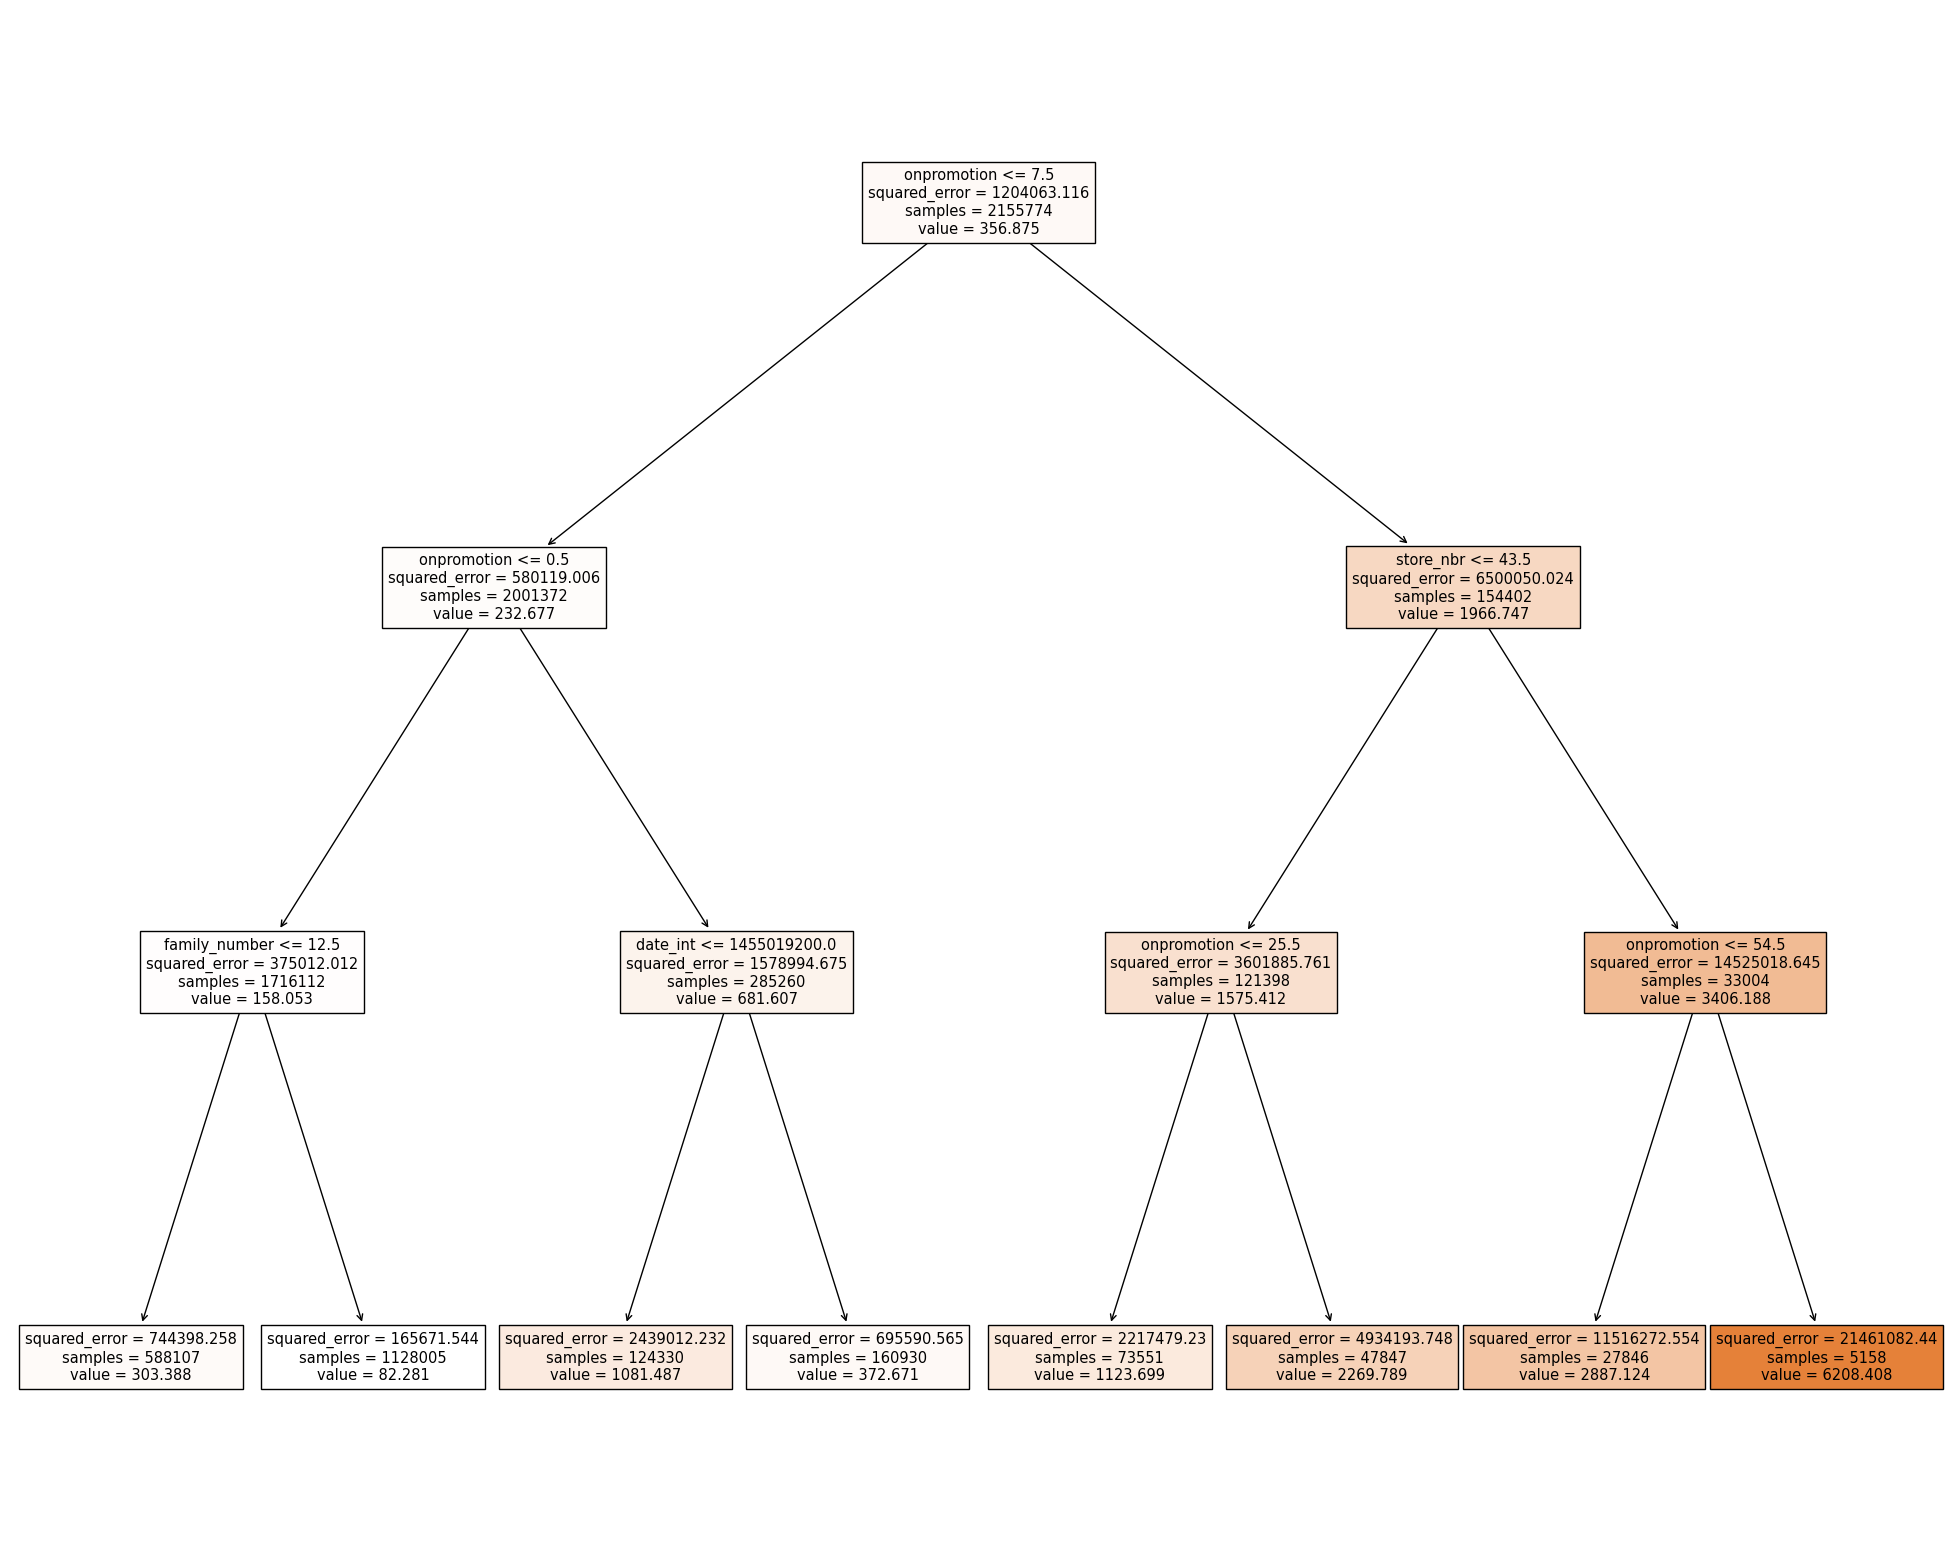

In [34]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(forest_oil_model, 
                   feature_names=['date_int', 'store_nbr', 'family_number','onpromotion', 'dcoilwtico', 'day_of_week'],  
                   filled=True)

## Create submission file

In [35]:
df_test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv',
    parse_dates=['date'])
df_test['date_int'] = df_test['date'].map(lambda a : int(round(a.timestamp())) )
df_test['family_number'] = df_test['family'].map(lambda a : family_enum[a] )

In [36]:
df_test.head(len(df_test))

,id,date,store_nbr,family,onpromotion,date_int,family_number
0,3000888,2017-08-16,1,AUTOMOTIVE,0,1502841600,0
1,3000889,2017-08-16,1,BABY CARE,0,1502841600,1
2,3000890,2017-08-16,1,BEAUTY,2,1502841600,2
3,3000891,2017-08-16,1,BEVERAGES,20,1502841600,3
4,3000892,2017-08-16,1,BOOKS,0,1502841600,4
...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,1504137600,28
28508,3029396,2017-08-31,9,PREPARED FOODS,0,1504137600,29
28509,3029397,2017-08-31,9,PRODUCE,1,1504137600,30
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,1504137600,31


Merge with oil dataframe for relevant dates:

In [37]:
df_test_merged = pd.merge(df_test[['date', 'date_int', 'store_nbr', 'family_number', 'onpromotion']]
                     , df_oil_weekend[['dcoilwtico', 'day_of_week', 'date_int']], on="date_int", how="left")
df_test_merged.head(len(df_test_merged))

,date,date_int,store_nbr,family_number,onpromotion,dcoilwtico,day_of_week
0,2017-08-16,1502841600,1,0,0,46.80,2
1,2017-08-16,1502841600,1,1,0,46.80,2
2,2017-08-16,1502841600,1,2,2,46.80,2
3,2017-08-16,1502841600,1,3,20,46.80,2
4,2017-08-16,1502841600,1,4,0,46.80,2
...,...,...,...,...,...,...,...
28507,2017-08-31,1504137600,9,28,1,47.26,3
28508,2017-08-31,1504137600,9,29,0,47.26,3
28509,2017-08-31,1504137600,9,30,1,47.26,3
28510,2017-08-31,1504137600,9,31,9,47.26,3


Drop any NaN values from dataframe:

In [38]:
df4=df_test_merged.dropna(subset=['date_int', 'store_nbr', 'family_number',
       'onpromotion', 'dcoilwtico', 'day_of_week']).reset_index(drop=True)
df4.head(len(df4))

,date,date_int,store_nbr,family_number,onpromotion,dcoilwtico,day_of_week
0,2017-08-16,1502841600,1,0,0,46.80,2
1,2017-08-16,1502841600,1,1,0,46.80,2
2,2017-08-16,1502841600,1,2,2,46.80,2
3,2017-08-16,1502841600,1,3,20,46.80,2
4,2017-08-16,1502841600,1,4,0,46.80,2
...,...,...,...,...,...,...,...
28507,2017-08-31,1504137600,9,28,1,47.26,3
28508,2017-08-31,1504137600,9,29,0,47.26,3
28509,2017-08-31,1504137600,9,30,1,47.26,3
28510,2017-08-31,1504137600,9,31,9,47.26,3


** It is good that no rows were dropped, since else we wouldn't be able to submit the resulting predictions (the submission data must have all the same id's)

We are now ready to define the new features to build the predictions with the model we trained:

In [39]:
test_x = df4[features]
predictions = forest_oil_model.predict(test_x)

In [40]:
predictions

array([ 303.38757099,  303.38757099,  372.67124334, ...,  372.67124334,
       1123.69941728,   82.28066533])

Finally, create submission dataframe and then submission csv file:

In [41]:
df_submission = df_test[['id']].copy() # creates a dataframe with the same id column, as this is required for submission 
df_submission['sales'] = pd.Series(predictions) 
df_submission.to_csv('/kaggle/working/submission.csv', index=False)

In [42]:
df_submission.head(len(df_submission))

,id,sales
0,3000888,303.387571
1,3000889,303.387571
2,3000890,372.671243
3,3000891,1123.699417
4,3000892,303.387571
...,...,...
28507,3029395,372.671243
28508,3029396,82.280665
28509,3029397,372.671243
28510,3029398,1123.699417
